In [25]:
# common imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

BANK_DATA_PATH = r"data/Bank Customer Churn Prediction.csv"

# Getting the Data

In [10]:
def load_data(path=BANK_DATA_PATH):
    return pd.read_csv(path)

In [11]:
bank = load_data()
bank.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# Analysis of the Data

In [12]:
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [13]:
# all customer id's are unique- so this column can be dropped
bank['customer_id'].nunique()

10000

In [14]:
bank['country'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

In [15]:
bank['gender'].value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

In [34]:
bank["churn"].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

In [85]:
churned_customers = bank[bank["churn"]==1]

# The amount of churn grouped by country

In [32]:
churn_by_country = bank.groupby(["country"]).agg(churn_amount=("churn",'sum'))
churn_by_country = churn_by_country.reset_index()
churn_by_country

,country,churn_amount
0,France,810
1,Germany,814
2,Spain,413


<AxesSubplot: xlabel='country', ylabel='churn_amount'>

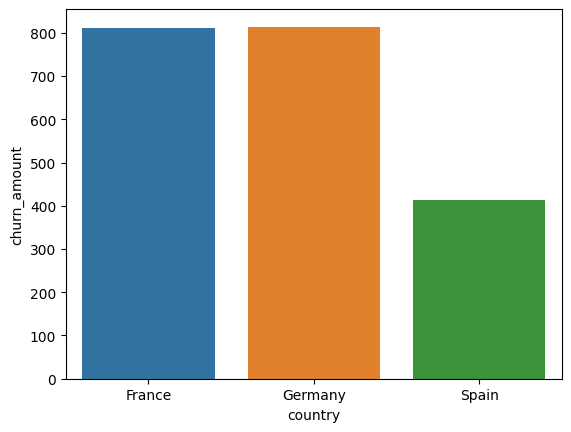

In [39]:
sns.barplot(x="country",
           y="churn_amount",
           data=churn_by_country)

# The amount of churn group by country and gender

In [37]:
churn_by_country_gender = bank.groupby(["country","gender"]).agg(churn_amount=("churn",'sum'))
churn_by_country_gender = churn_by_country_gender.reset_index()
churn_by_country_gender

,country,gender,churn_amount
0,France,Female,460
1,France,Male,350
2,Germany,Female,448
3,Germany,Male,366
4,Spain,Female,231
5,Spain,Male,182


<AxesSubplot: xlabel='country', ylabel='churn_amount'>

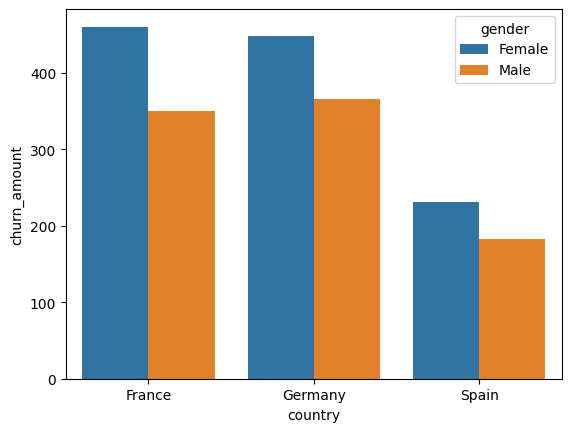

In [41]:
sns.barplot(x="country",
           y="churn_amount",
           hue="gender",
           data=churn_by_country_gender)

# The mean age of the people that churned

In [59]:
churned_mean_age_per_country = churned_customers.groupby(["country","gender"]).agg(mean_age=("age",'mean'))
churned_mean_age_per_country = churned_mean_age_per_country.reset_index()
churned_mean_age_per_country

,country,gender,mean_age
0,France,Female,45.332609
1,France,Male,44.871429
2,Germany,Female,44.828125
3,Germany,Male,44.975410
4,Spain,Female,43.610390
5,Spain,Male,44.829670


# The percentage of churned people

In [78]:
churn_percentage = churned_customers["country"].value_counts() / bank['country'].value_counts()

In [82]:
churn_percentage_df = pd.DataFrame({'Country':churn_percentage.index, 'churn percentage':churn_percentage.values})
churn_percentage_df

,Country,churn percentage
0,France,0.161548
1,Germany,0.324432
2,Spain,0.166734


<AxesSubplot: xlabel='Country', ylabel='churn percentage'>

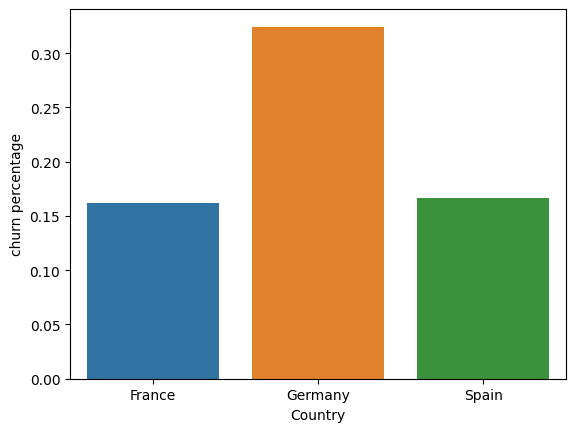

In [84]:
sns.barplot(x="Country",
           y="churn percentage",
           data=churn_percentage_df)

# Average credit score grouped by country and gender

In [97]:
avg_credit_score_country_gender = bank.groupby(["country","gender"]).agg(mean_age=("credit_score",'mean'))
avg_credit_score_country_gender = avg_credit_score_country_gender.reset_index()

<AxesSubplot: xlabel='country', ylabel='mean_age'>

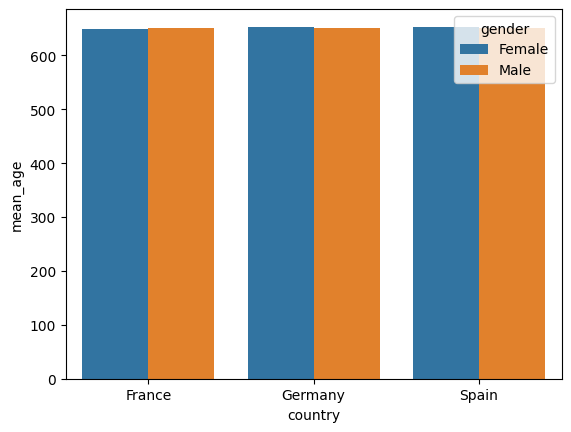

In [98]:
sns.barplot(x="country",
           y="mean_age",
           hue="gender",
           data=avg_credit_score_country_gender)